# Using and Removing Seasonality

Time series datasets can contain a seasonal component. This is a cycle that repeats over time - month or yearly. Repeating cycles may obscure the signal that you wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

## Benefits to Machine Learning

Understanding the seasonal component in time series can imporve the performance of modeling with machine learning. This can happen in two primary ways:
- Clearer Signal: Identifying and removing the seasonal component from the time series can result in clearer relationships between input and output variables
- More information: additional information about the seasonal compoentn of the time series can provide new information to imporove model performance

Modeling seasonality and removing it from the time series may occur during data cleaning and preparation. Extracting seasonal information and providing it as input features, either directly or in summary form, may occu during feature extraction and feature engineering activities

## Types of Seasonality
- Time of day
- Daily
- Weekly
- Monthly
- Yearly

## Removing Seasonality

### Seasonal Adjustment with Differencing

A simple way to correct for a seasonal component is to use differencing. If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week.

Populating the interactive namespace from numpy and matplotlib


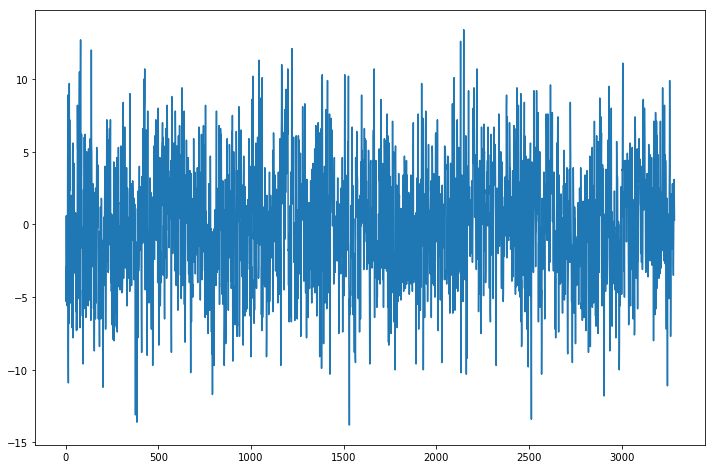

In [20]:
#Deseasonalize a time series using differencing
from pandas import read_csv
from matplotlib import pyplot
%pylab inline
pylab.rcParams['figure.figsize'] = (12,8)

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)
X=series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

The minimum temperature dataset contains two leap years (1984 and 1988) which are not explicitly handled so obvesrvations in March 1983 and onwards are offset by one day, followed by another in March 1988. You can consider that the the temperature within any given period of the year is probably stable, probably over a few weeks. 

An improved model may be to subtract the average temperature from the same calendar month in the previous year, rather than the same day. Thisi can be done by resampling the dataset to a monthly average minimum temperature.

Date
1981-01-31    17.712903
1981-02-28    17.678571
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
1981-06-30     7.306667
1981-07-31     7.577419
1981-08-31     7.238710
1981-09-30    10.143333
1981-10-31    10.087097
1981-11-30    11.890000
1981-12-31    13.680645
1982-01-31    16.567742
Freq: M, Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


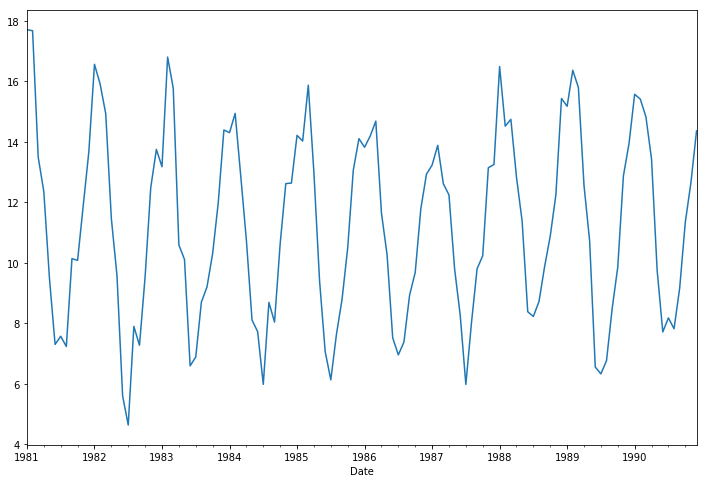

In [21]:
# Calculate and plot monthly average
from pandas import read_csv
from matplotlib import pyplot

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)
resample = series.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(13))
monthly_mean.plot()
pyplot.show()


You can test the same differencing method on the monthly data and confirm that the seasonally adjusted dataset does indeed remove the yearly cycles. Running the code below creates a new seasonally adjusted monthly minimum temperature dataset, skipping the first year of data in order to create the adjustement.

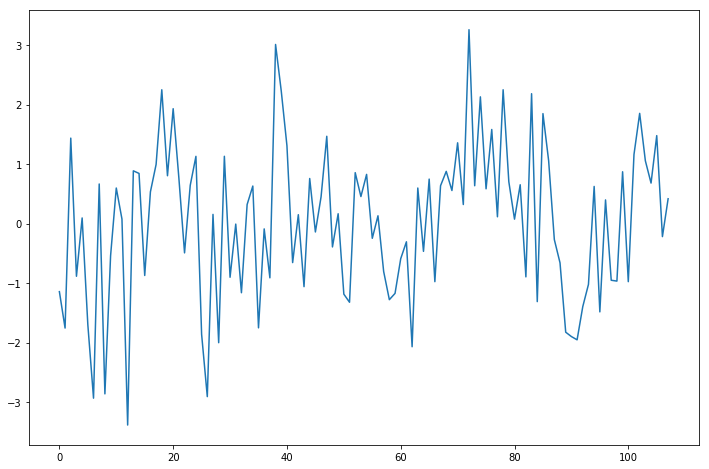

In [22]:
# Deseasonalize monthly data by differencing
from pandas import read_csv
from matplotlib import pyplot as pt

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)

resample = series.resample('M')
monthly_mean = resample.mean()
X = series.values
diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i - months_in_year]
    diff.append(value)
pt.plot(diff)
pt.show()

Next, you can use the monthly average minimum temperatures from the same month in the previous year to adjust the daily minimum temperature dataset. Again, the first year of data is skipped, but the correction using the monthly rather than the daily data may be a more stable approach.

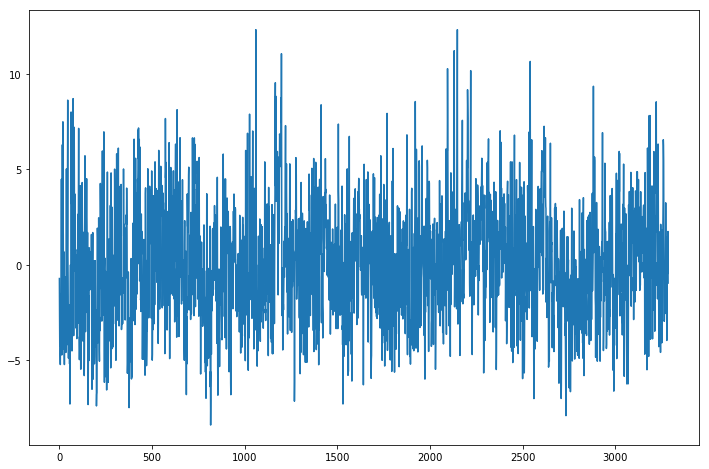

In [23]:
# Deseasonalize a time series using month-based differencing
from pandas import read_csv
from matplotlib import pyplot as pt

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)

X = series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    month_str = str(series.index[i].year-1) + '-' + str(series.index[i].month)
    month_mean_last_year = series[month_str].mean()
    value = X[i] - month_mean_last_year
    diff.append(value)
pt.plot(diff)
pt.show()

## Seasonal Adjustment with Modeling

We can model the seasonal component directly, then subtract it from the observations. The seasonal component in a given time series is likely a sine wave over a generally fixed period and amplitude. This can be approximated easily using a curve-fitting method. A dataset can be constructed with the time index of the sine wave as an input, or x-axis, and the observation as the output, or y-axis.

Once fit, the model can then be used to calculate a seasonal component for any time index. In the case of the temperature data, the time index would be the day of the year. We can then estimate the seasonal component for the day of the year for any historical observations or any new observations in the future. The curve can then be used as a new input for modeling with supervised learning algorithms, or subtracted from observations to create a seasonally adjusted series.



Coefficients: [ -1.17308000e-08   9.30253946e-06  -2.15977594e-03   1.19147966e-01
   1.38980178e+01]


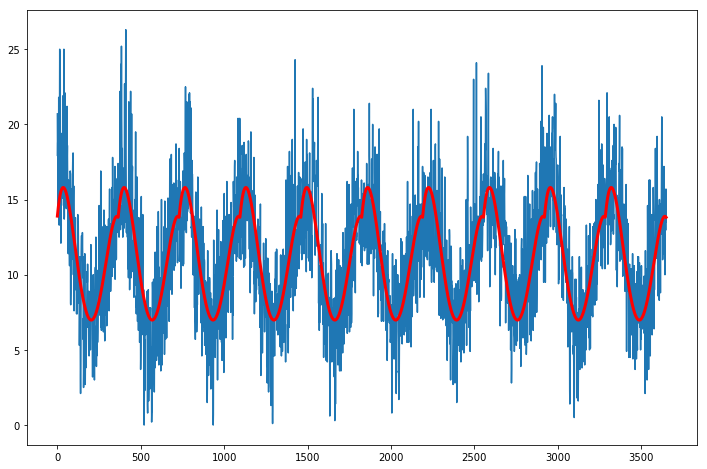

In [25]:
# Model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot as pt
from numpy import polyfit

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)

#fit polynomial: x^2*b1 +x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

# Create Curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
pt.plot(series.values)
pt.plot(curve, color='red', linewidth=3)
pt.show()

Running the example above creates the dataset, fits the curve, predicts the value for each day in the dataset, and then plots the resulting seasonal model over the top of the original dataset. One limitation of this model is that it does not take into account of leap days, adding small offset noise that could easily be corrected with an update to the approach. For example, we could just remove the two February 29 observations from the dataset when creating the seasonal model.

The curve apepars to be a good fit for the seasonal structure in the dataset. You can now use the model to create a seasonally adjusted version of teh dataset:

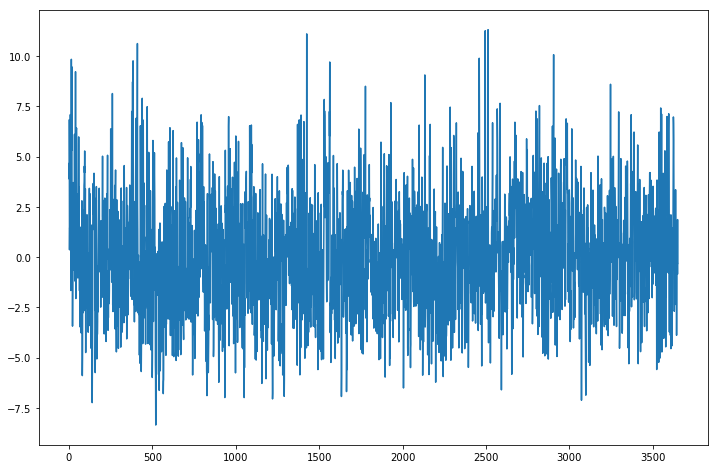

In [28]:
# Deseasonalize by differencing with a polynomial model
from pandas import read_csv
from matplotlib import pyplot as pt
from numpy import polyfit

series = read_csv('daily-minimum-temperatures.csv', header=0, parse_dates=[0], 
                  index_col = 0, nrows=3650, squeeze=True)
series = series.map(lambda x: x.lstrip('?'))
series = series.astype(float)

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)

# Create Curves
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# Create Seasonal Adjustment
values = series.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
#plot
pt.plot(diff)
pt.show()

Running the example above subtracts the values predicted by the seasonal model from the original observations; the seasonally adjusted dataset is then plotted.

# Summary

- The importance of seasonality in time series and the opportunities for data preparation and feature eng